## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats
import itertools

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [12]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
ReparaStd = 10
BatchSize = 10000

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [13]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

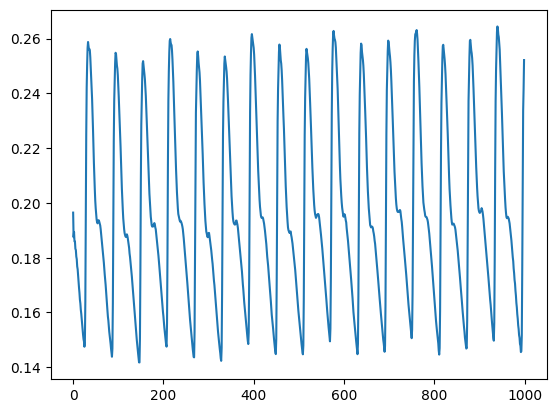

In [4]:
plt.plot(ValData[9])

### Post model

In [40]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame_14 (TFOpLambda) (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional_36 (Bidirectional (None, 20, 50)       11550       tf.signal.frame_14[0][0]         
__________________________________________________________________________________________________
bidirectional_37 (Bidirectional (None, 20, 50)       11550       bidirectional_36[0][0]           
_

In [15]:
def FFT_PS(Data, Metric, MinFreq = 1, MaxFreq = 51):
    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    PSD = (FFTRes**2)/FFTRes.shape[-1]
    
    # Probability Density Function
    PSPDF = PSD / np.sum(PSD, axis=(1, 2),keepdims=True)
    
    # Power Spectral Entropy
    PSE = -np.sum(PSPDF * np.log(PSPDF), axis=-1)
    # Probability Density Function for Power Spectral Entropy
    PSEPDF = PSE / np.sum(PSE, axis=(-1),keepdims=True)
    
    
    if 'PSD' in Metric:
        Value = PSD
    elif 'PSPDF' in Metric:
        Value = PSPDF
        
    # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
    Max_Value_Label = np.argmax(Value, axis=-1) + 1
    ### Calculating mode values of MaxV_NG_ZFc; To index the max frequency, 1 is subtracted from the modes.
    Mode_Value = stats.mode(Max_Value_Label.T, axis=0, keepdims=False)[0] - 1
    ### (NMiniBat, Frequency_idx, NGen)
    TransValue = np.transpose(Value, (0, 2,1))
    #### Selecting variance values by the order of NMiniBat and Frequency_idx
    Max_Value = TransValue[np.arange(NMiniBat), Mode_Value]
    
    
    if 'PSD' == Metric:
        # (NMiniBat, NGen, NFreq)
        return PSD
    elif 'PSPDF'  == Metric:
        # (NMiniBat, NGen, NFreq)
        return PSPDF
    elif 'PSE'  == Metric:
        # (NMiniBat, NFreq)
        return PSE
    elif 'PSEPDF' == Metric:
        # (NMiniBat, NFreq)
        return PSEPDF
    elif 'Max_PSD' == Metric:
        # (NMiniBat, NFreq)
        return Max_Value
    elif 'Max_PSPDF' == Metric:
        # (NMiniBat, NFreq)
        return Max_Value
    
    
def ProbPermutation(Data, Nframe=3, EpsProb = 1e-7):
    
    # Generate true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(Nframe)))).reshape(-1, Nframe)

    # Get all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=Nframe, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None] == PermsTable[:,:,None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    CountPerms = np.sum(CountPerms, axis=(1))
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, EpsProb)    



def ProbFreq (Data, NMiniBat, NGen, Axis, MeanZj=None, Metric ='PSD', MinFreq = 1, MaxFreq = 51, EpsProb = 1e-7):

    ### Conducting FFT 
    # Power Spectral Density
    PSD = FFT_PS(Data, Metric=Metric, MinFreq = MinFreq, MaxFreq = MaxFreq)

    ### Max PSD label
    MaxPSDLabel = np.argmax(PSD, axis=-1) + 1
    MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

    if Axis =='All':
        # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
        MaxV, Count = np.unique(MaxPSDLabel, return_counts=True)
        MaxVLabelCount[MaxV] = Count

        ### Probability of frequencies 
        Prob = MaxVLabelCount / np.sum(MaxVLabelCount)

    elif Axis =='One':
        MaxVLabelCount = []
        MaxV_MeanZj = []
        # Mini batch-wise max freqeuncy count
        for num, mini in enumerate(MaxPSDLabel):
            
            if MeanZj is not None: # To identify at which z-value the maximum of a particular frequency is often formed.
                MeanZj = MeanZj.reshape(NMiniBat, NGen, -1)
                MaxV_MeanZj.append(np.mean(MeanZj[num], axis=0)[None]) 
                
            Count_ = np.zeros_like(MaxVLabelIDX)
            MaxV, Count = np.unique(mini, return_counts=True)
            Count_[MaxV] = Count
            MaxVLabelCount.append(Count_[None])

        # (Batch_size, N_frequency)
        MaxVLabelCount = np.concatenate(MaxVLabelCount)    
        Prob = MaxVLabelCount / NGen 
    
    if MeanZj is not None:
        return np.maximum(Prob, EpsProb), np.concatenate(MaxV_MeanZj)    
    else:
        return np.maximum(Prob, EpsProb)
    
    
def Sampler (Data):
    #Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    #Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    #FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, Zs_Out)
    return Sampler.predict(Data, batch_size=BatchSize, verbose=1)   

In [16]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 500
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05

In [43]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))
 

### monte carlo approximation
I_V_Z = 0
I_V_ZjZ = 0
I_V_Zj = 0
I_V_FRZj = 0
I_V_FAZj = 0
I_VE_FMZj = 0
I_VE_FAZj = 0

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
          
            print('Sampling Samp_Zs and Samp_Fc')
            # Sampling
            SplitData_Ext =  np.broadcast_to(SplitData[mini][:, None], (NMiniBat, NGen, SplitData[mini].shape[-1])).reshape(-1, SplitData[mini].shape[-1])
            Samp_Z = Sampler(SplitData_Ext)
            FCs = np.random.rand(NMiniBat *NGen, NFCs) * FcLimit
            
            print('Predicting SigGen_ZFc')
            # Reconstruction; y ~ Q(Y | Z, Fc)Q(Z, Fc | Y)
            #FeatGen_ZFc = FeatGenModel.predict([FCs[:, :2],FCs[:, 2:], Samp_Z], batch_size=BatchSize, verbose=1)
            #SigGen_ZFc = ReconModel.predict([FeatGen_ZFc], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            SigGen_ZFc = GenModel.predict([FCs[:, :2],FCs[:, 2:], Samp_Z], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            

            # Masking for selecting Samp_Zj from Samp_Z by assuming Zs with indices other than j have mean values '0' of Guassian dist.
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            Samp_Zj = Samp_Z * Mask_Z
            
            
            print('Predicting SigGen_ZjFc')
            # Reconstruction; y ~ Q(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); Assuming Zs with indices other than j have mean values '0'; j~U(), Z~N(0, std), and Fc ~ Bern(x;μ=0.5) x FcLimit
            #FeatGen_ZjFc = FeatGenModel.predict([FCs[:, :2],FCs[:, 2:], Samp_Zj], batch_size=BatchSize, verbose=1)
            #SigGen_ZjFc = ReconModel.predict([FeatGen_ZjFc], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            SigGen_ZjFc = GenModel.predict([FCs[:, :2],FCs[:, 2:], Samp_Zj], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            # Selecting Samp_Zj from Guassian dist by assuming Zs with indices other than j have mean values '0' of Guassian dist and repeat the values NGen times.
            Samp_ZjRPT = []
            for i in range(NMiniBat):
                Mask_Z = np.zeros((LatDim))
                # LatDim-wise Z sampling
                Mask_Z[ np.random.choice(LatDim, NSelZ,replace=False )]= np.random.normal(0, ReparaStd)
                # Setting the same Z value within the N generated signals (NGen).
                Samp_ZjRPT.append(np.broadcast_to(Mask_Z[None], (NGen,LatDim))[None]) 
            Samp_ZjRPT = np.concatenate(Samp_ZjRPT).reshape(NMiniBat *NGen, LatDim)
            
            
            
            print('Predicting SigGen_ZjFcRPT')
            # Reconstruction; y ~ P(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); j~U() Fc~U() and Z~N(0, std) 
            # Assuming all FC values ∼Bern(x;μ=0.5) 
            #FeatGen_ZjFcRPT = FeatGenModel.predict([FCs[:, :2], FCs[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1)
            #SigGen_ZjFcRPT = ReconModel.predict([FeatGen_ZjFcRPT], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            SigGen_ZjFcRPT = GenModel.predict([FCs[:, :2], FCs[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            print('Predicting SigGen_ZjFcAr')
            # Reconstruction; y ~ P(Y | Fc, Zj)Q(Zj); 
            # The Fc values on FC_Arange (FcAr) are generated based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            #FeatGen_ZjFcAr = FeatGenModel.predict([FC_Arange[:, :2], FC_Arange[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1)
            #SigGen_ZjFcAr = ReconModel.predict([FeatGen_ZjFcAr], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            SigGen_ZjFcAr = GenModel.predict([FC_Arange[:, :2], FC_Arange[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            
            
            print('Predicting SigGen_ZjFcMu')
            # Reconstruction; y ~ P(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); j~U() Fc~U() and Z~N(0, std) 
            # Assuming all FC_μ x FcLimit + eps, FC_μ=0.5, eps ~ N(0, 0.5*FcLimit*FCmuEps)
            Rand_FCs = np.zeros_like(FCs) + FcLimit * 0.5 + np.random.normal(0, (FcLimit * 0.5)*FCmuEps, (FCs.shape))
            #FeatGen_ZjFcMu = FeatGenModel.predict([Rand_FCs[:, :2], Rand_FCs[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1)
            #SigGen_ZjFcMu = ReconModel.predict([FeatGen_ZjFcMu], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
            SigGen_ZjFcMu = GenModel.predict([Rand_FCs[:, :2], Rand_FCs[:, 2:], Samp_ZjRPT], batch_size=BatchSize, verbose=1).reshape(NMiniBat, NGen, -1)
                             
                
            # Max frequency wise values
            Q_V = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'All', Metric='PSD',  MinFreq = 1, MaxFreq = 51)
            Q_V_Z = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj = ProbFreq (SigGen_ZjFc, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FR = ProbFreq (SigGen_ZjFcRPT, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj_FA = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            #Q_V_Zj_FA, MaxV_MeanZj = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', MeanZj=Samp_Zj, Metric='PSD', MinFreq = 1, MaxFreq = 51)
            
            
            
            # Max frequency entropy-wise values
            MaxPSD_ZjFcRPT = FFT_PS(SigGen_ZjFcRPT, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcMu = FFT_PS(SigGen_ZjFcMu, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcAr = FFT_PS(SigGen_ZjFcAr, 'Max_PSD', MinFreq = 1, MaxFreq = 51)

            
            # Calculate the permutation entropy based on the PSD values of the frequency with the max PSD from generated signals.
            Q_VE = ProbPermutation(MaxPSD_ZjFcRPT, Nframe=3)
            Q_VE_Zj_FM = ProbPermutation(MaxPSD_ZjFcMu, Nframe=3)
            Q_VE_Zj_FA = ProbPermutation(MaxPSD_ZjFcAr, Nframe=3)


            
            # I(V;Z)
            I_V_Z_ = np.mean(np.sum(Q_V_Z * np.log(Q_V_Z / Q_V[None]), axis=-1))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_
            
            # I(V;Zj|Z)
            I_V_ZjZ_ = np.mean(np.sum(Q_V_Zj * np.log(Q_V_Zj / Q_V_Z), axis=-1))
            print('I_V_ZjZ : ', I_V_ZjZ_)
            I_V_ZjZ += I_V_ZjZ_
            
            
            
            # I(V;Zj)
            I_V_FRZj_ = np.mean(np.sum(Q_V_Zj_FR * np.log(Q_V_Zj_FR / Q_V), axis=-1))
            print('I_V_FRZj : ', I_V_FRZj_)
            I_V_FRZj += I_V_FRZj_
            
            # I(V;FC|Zj)
            I_V_FAZj_ = np.mean(np.sum(Q_V_Zj_FA * np.log(Q_V_Zj_FA / Q_V_Zj_FR), axis=-1))
            print('I_V_FAZj : ', I_V_FAZj_)
            I_V_FAZj += I_V_FAZj_
            
            
            
            # I(VE;Zj)
            I_VE_FMZj_ = np.mean(np.sum(Q_VE_Zj_FM * np.log(Q_VE_Zj_FM / Q_VE), axis=-1))
            print('I_VE_FMZj : ', I_VE_FMZj_)
            I_VE_FMZj += I_VE_FMZj_
            
            # I(VE;FC|Zj)
            I_VE_FAZj_ = np.mean(np.sum(Q_VE_Zj_FA * np.log(Q_VE_Zj_FA / Q_VE_Zj_FM), axis=-1))
            print('I_VE_FAZj : ', I_VE_FAZj_)
            I_VE_FAZj += I_VE_FAZj_
            
            
            t.update(1)


# CMI(V;Zj, Z)
I_V_Z /= (MASize*SimSize)
I_V_ZjZ /= (MASize*SimSize)
CMI_V_ZjZ = I_V_Z + I_V_ZjZ             

# CMI(V;FC,Zj)
I_V_FRZj /= (MASize*SimSize)
I_V_FAZj /= (MASize*SimSize)
CMI_V_FCZj = I_V_FRZj + I_V_FAZj             

# CMI(VE;FA,FM)
I_VE_FMZj /= (MASize*SimSize)
I_VE_FAZj /= (MASize*SimSize)
CMI_VE_FAFM = I_VE_FMZj + I_VE_FAZj             


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 21ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 55ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 54ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 55ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 60ms/step


  1%|▋                                                                                 | 1/120 [00:08<16:56,  8.54s/it]

I_V_Z :  0.1168314170923108
I_V_ZjZ :  1.3165526423828087
I_V_FRZj :  2.5409109012982065
I_V_FAZj :  0.2503254544710936
I_VE_FMZj :  0.03726262858717553
I_VE_FAZj :  0.823690393246312
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 17ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 54ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 58ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 56ms/step


  2%|█▎                                                                                | 2/120 [00:17<16:44,  8.51s/it]

I_V_Z :  0.11749511749604226
I_V_ZjZ :  1.2954046286471057
I_V_FRZj :  2.6051364180888275
I_V_FAZj :  0.24360365273728501
I_VE_FMZj :  0.03615647515570919
I_VE_FAZj :  0.8167548333685901
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 18ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 59ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 59ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 57ms/step


  2%|██                                                                                | 3/120 [00:25<16:44,  8.58s/it]

I_V_Z :  0.1192721485413733
I_V_ZjZ :  1.3193821030805477
I_V_FRZj :  2.7090589416573443
I_V_FAZj :  0.23206012900210643
I_VE_FMZj :  0.03655085658212957
I_VE_FAZj :  0.8327025797863756
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 18ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 63ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 64ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 56ms/step


  3%|██▋                                                                               | 4/120 [00:34<16:52,  8.73s/it]

I_V_Z :  0.12051115938215912
I_V_ZjZ :  1.3135080426806856
I_V_FRZj :  2.6475461034662113
I_V_FAZj :  0.19901795106960754
I_VE_FMZj :  0.0364472707161768
I_VE_FAZj :  0.8110902582046299
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 17ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 52ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 51ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 56ms/step


  4%|███▍                                                                              | 5/120 [00:43<16:35,  8.66s/it]

I_V_Z :  0.11912422399515504
I_V_ZjZ :  1.3105899099096527
I_V_FRZj :  2.6585204148008232
I_V_FAZj :  0.18886352144474358
I_VE_FMZj :  0.03604378643306941
I_VE_FAZj :  0.8257014843937216
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 20ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 61ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 60ms/step


  5%|████                                                                              | 6/120 [00:51<16:27,  8.66s/it]

I_V_Z :  0.11796018253129263
I_V_ZjZ :  1.282348807681873
I_V_FRZj :  2.6047506235262285
I_V_FAZj :  0.2310423946031032
I_VE_FMZj :  0.03697761283906328
I_VE_FAZj :  0.8098929434026377
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 17ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 61ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 55ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 58ms/step


  6%|████▊                                                                             | 7/120 [01:00<16:12,  8.61s/it]

I_V_Z :  0.12068540146280615
I_V_ZjZ :  1.3182267574989732
I_V_FRZj :  2.656944024450405
I_V_FAZj :  0.19934938317999548
I_VE_FMZj :  0.0398796831863496
I_VE_FAZj :  0.8153068074076412
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 18ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 54ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 54ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 52ms/step


  7%|█████▍                                                                            | 8/120 [01:08<15:54,  8.52s/it]

I_V_Z :  0.11686599773286682
I_V_ZjZ :  1.321912247051552
I_V_FRZj :  2.575813126872995
I_V_FAZj :  0.2466303749689006
I_VE_FMZj :  0.03532862890799247
I_VE_FAZj :  0.8176272421371868
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 17ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 57ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 52ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 56ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 53ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 57ms/step


  8%|██████▏                                                                           | 9/120 [01:17<15:49,  8.55s/it]

I_V_Z :  0.11849224824443913
I_V_ZjZ :  1.3455055413086325
I_V_FRZj :  2.610762035032395
I_V_FAZj :  0.21900597460821233
I_VE_FMZj :  0.037688407503780906
I_VE_FAZj :  0.8199494038528501
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 1s 18ms/step
Predicting SigGen_ZFc
5/5 [==============================] - 0s 58ms/step
Predicting SigGen_ZjFc
5/5 [==============================] - 0s 61ms/step
Predicting SigGen_ZjFcRPT
5/5 [==============================] - 0s 63ms/step
Predicting SigGen_ZjFcAr
5/5 [==============================] - 0s 62ms/step
Predicting SigGen_ZjFcMu
5/5 [==============================] - 0s 58ms/step


KeyboardInterrupt: 